In [1]:
import maboss
from tqdm import tqdm
import os
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

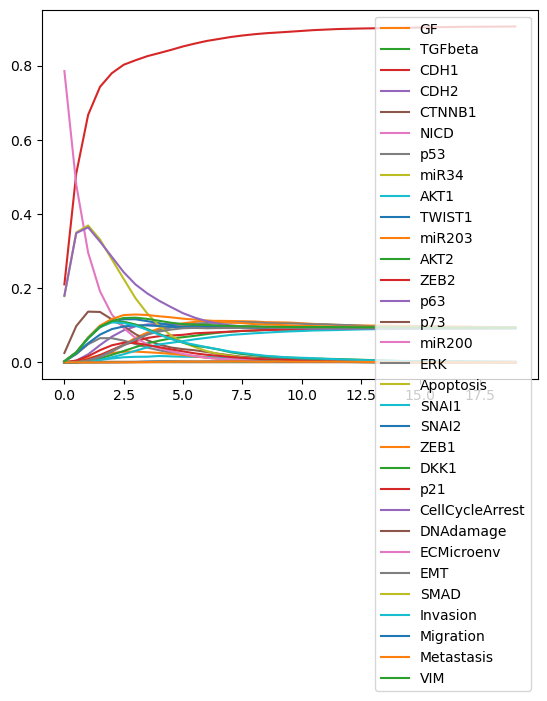

In [2]:
model = maboss.loadBNet('/home/spankaew/Git/BooleanBenchmark/models/Invasion/Invasion_0.bnet')
model.update_parameters(max_time = 20)
model.network.set_istate('miR200',[0,1])

simulation = model.run()
simulation.plot_node_trajectory()
model_nodes = model.network.names

In [3]:
# Create blank file to get the results
ensemble_results = {}

path = '/home/spankaew/Git/BooleanBenchmark/models/Invasion/' 
model_list = os.listdir(path)

mir_list = ['miR200','miR203','miR34']
model_nodes = model.network.names

for model in tqdm(model_list):

    # Load model
    simulations = maboss.loadBNet(path + model)

    # Setup the model initial condition
    ## Put all inputs at 0
    for i in model_nodes:
        simulations.network.set_istate(i,[1,0])
    ## Put all miR at 1
    for i in mir_list:
        simulations.network.set_istate(i,[0,1])

    # Modify the parameter of the model
    simulations.update_parameters(sample_count = 10000,
                                  thread_count = 15,
                                  max_time = 20,
                                  time_tick = 1)
    simulations.network.set_output(simulations.network.names)

    # Perform simulations
    result = simulations.run()

    # Get matrix
    model_mtx = result.get_nodes_probtraj().copy()

    # Setup cell matrix
    ## Cells
    model_mtx['model_id'] = model.replace('.bnet','')
    ## Timepoint
    model_mtx['timepoint'] = model_mtx.index
    ## Change index
    model_mtx.index = model_mtx.index.map(str)
    model_mtx.index = model + '_' + model_mtx.index

    # Concatenate model results in dictionary
    ensemble_results[model] = model_mtx

# Save the simulation to /tmp folder
simulation_df = pd.concat(ensemble_results.values(), ignore_index = True)
simulation_df.to_csv('/home/spankaew/Git/BooleanBenchmark/tmp/Invasion_simulation_miR.csv')

  0%|          | 0/1024 [00:00<?, ?it/s]

100%|██████████| 1024/1024 [11:19<00:00,  1.51it/s]


In [3]:
cl_df = pd.read_csv('/home/spankaew/Git/BooleanBenchmark/tmp/Invasion_simulation_miR.csv', index_col = 0)
cl_df.index = cl_df.model_id + '_' + [str(f) for f in cl_df.timepoint]
cl_df.index.name = None

In [4]:
adata = sc.AnnData(cl_df.drop(['model_id','timepoint'],axis = 1))
adata.obs['timepoint'] = cl_df['timepoint']
adata.obs['model_id'] = cl_df['model_id']

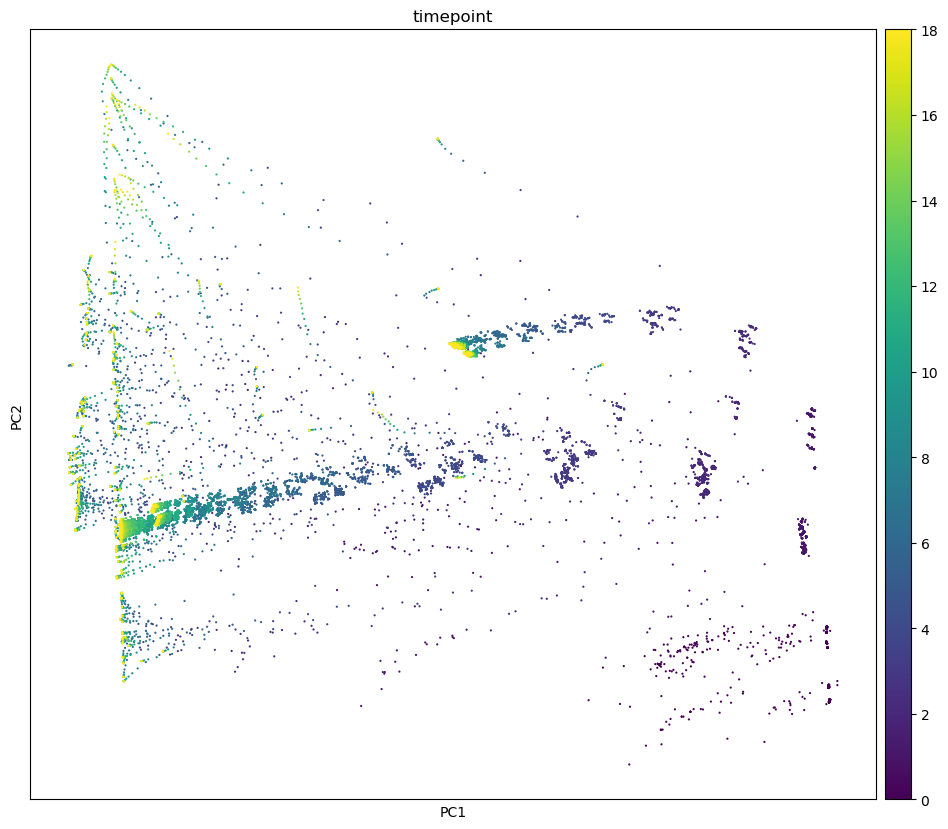

In [5]:
# Calculate PCA
sc.tl.pca(adata, svd_solver='arpack')

# plot 
from matplotlib.pyplot import rc_context
with rc_context({"figure.figsize": (12, 10)}):
    sc.pl.pca(adata, color = 'timepoint', size = 10)

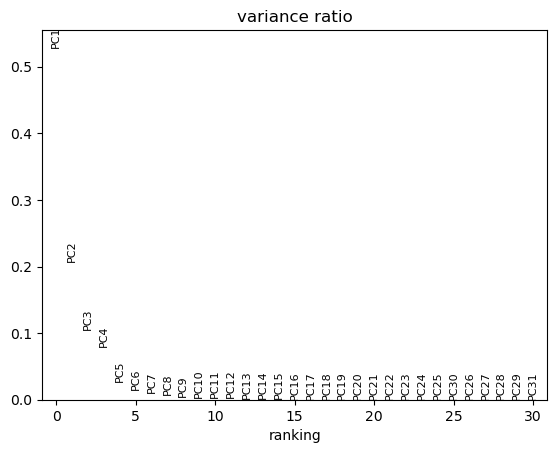

In [6]:
sc.pl.pca_variance_ratio(adata)

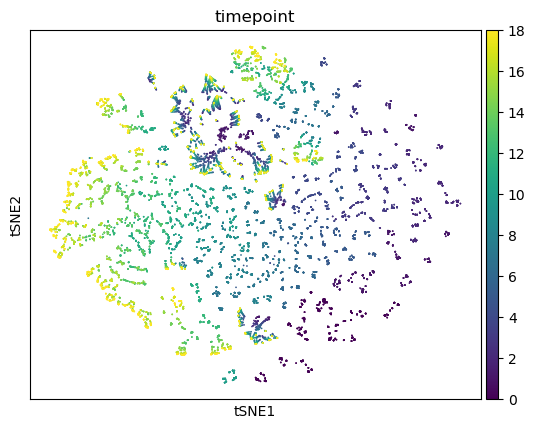

In [95]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=4)
sc.tl.tsne(adata, n_pcs = 4)
sc.pl.tsne(adata, color=["timepoint"])

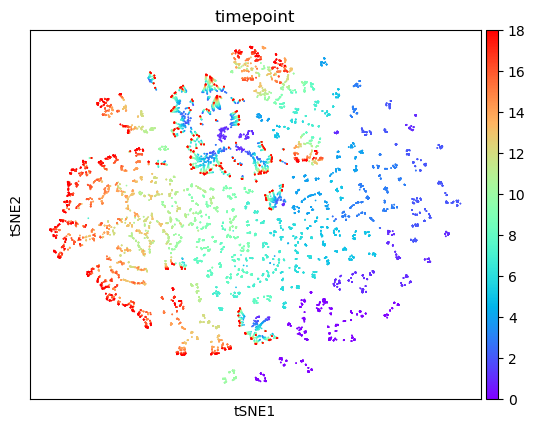

In [96]:
sc.pl.tsne(adata, color=["timepoint"], cmap = 'rainbow')

In [102]:
tsne_mat = [array[:2] for array in adata.obsm['X_tsne']]
tsne_mat = pd.DataFrame(tsne_mat, columns= ['tsne1','tsne2'])
tsne_mat.index = adata.obs.index
tsne_mat = pd.concat([tsne_mat, adata.obs], axis = 1,ignore_index = False)

tsne_mat['kmean_cluster'] = tsne_mat.model_id.replace(cluster_dict)

In [104]:
import plotly.graph_objects as go

# Create a trace
trace = go.Scatter3d(
    x=tsne_mat['tsne1'], 
    y=tsne_mat['tsne2'], 
    z=tsne_mat['timepoint'],
    mode='markers',
    marker=dict(
        size=5,
        color=tsne_mat['timepoint'],  # set color to the 'timepoint' values
        #colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)

# Create the 3D plot
fig = go.Figure(data=[trace])

# Customize layout
fig.update_layout(
    title='Interactive 3D Scatter Plot',
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='TIMEPOINT'
    ),
    margin=dict(r=0, b=0, l=0, t=0)  # tight layout
)

# Show the plot
fig.show()

In [ ]:
umap_mat = [array[:2] for array in adata.obsm['X_umap']]
umap_mat = pd.DataFrame(umap_mat, columns= ['umap1','umap2'])
umap_mat.index = adata.obs.index
umap_mat = pd.concat([umap_mat, adata.obs], axis = 1,ignore_index = False)
umap_mat

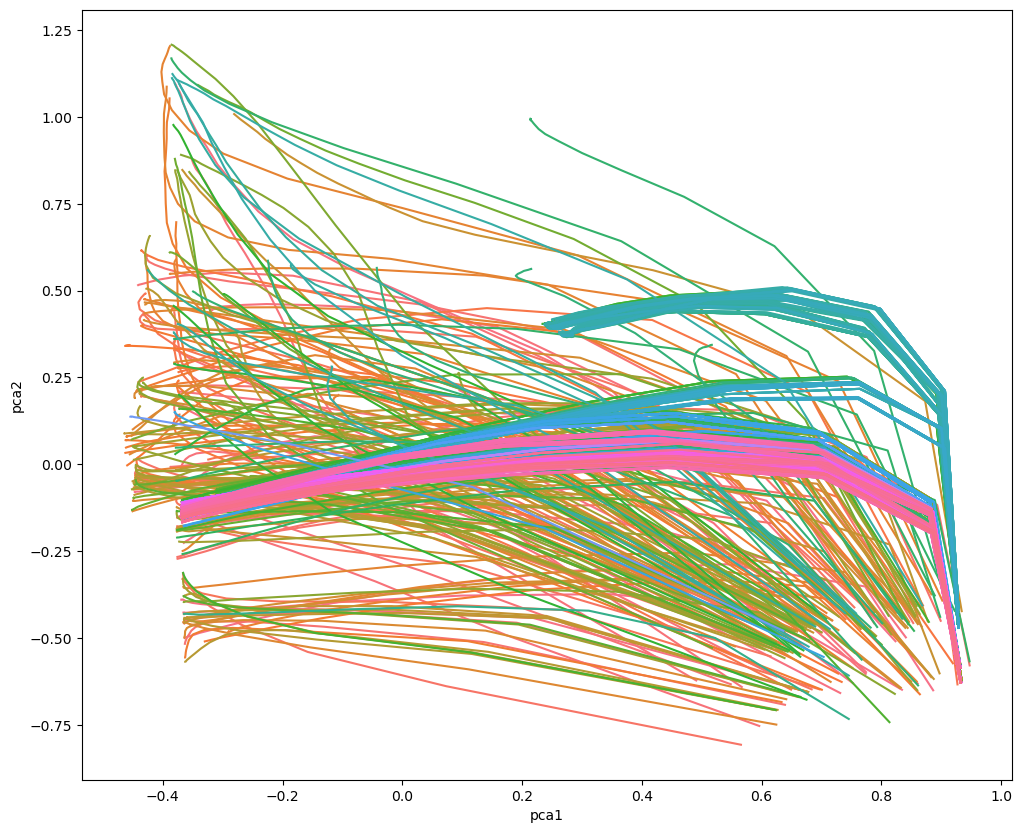

In [7]:
# Convert the PCA position to timeseries data
pca_mat = [array[:2] for array in adata.obsm['X_pca']]
pca_mat = pd.DataFrame(pca_mat, columns= ['pca1','pca2'])
pca_mat.index = adata.obs.index
pca_mat = pd.concat([pca_mat, adata.obs], axis = 1,ignore_index = False)

# plot
import seaborn as sns
with rc_context({"figure.figsize": (12, 10)}):
    plot = sns.lineplot(data = pca_mat, x = 'pca1',y='pca2',hue = 'model_id', sort = False)
    plot.get_legend().remove()

plt.show()

# Trajectory comparison using single variable from PCA

In [8]:
import tslearn
from tslearn.datasets import CachedDatasets
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.preprocessing import TimeSeriesResampler
import numpy


seed = 0
numpy.random.seed(seed)

Euclidean k-means
0.256 --> 0.177 --> 0.171 --> 0.169 --> 0.168 --> 0.168 --> 0.168 --> 0.168 --> 


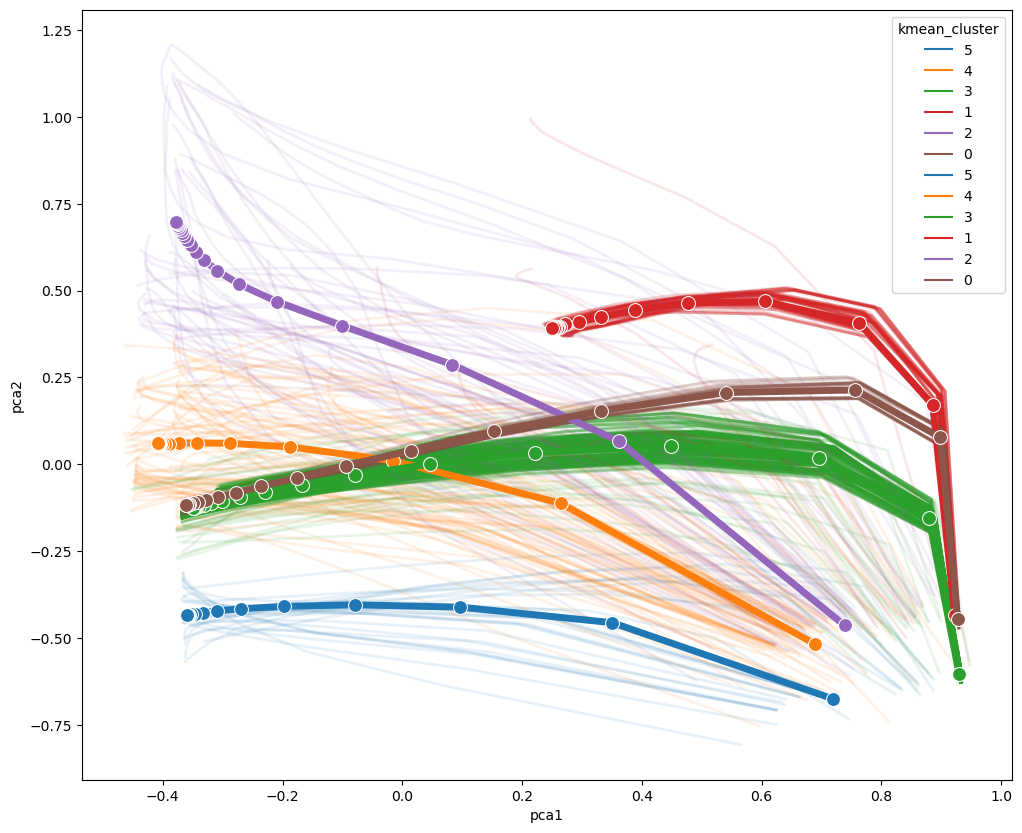

In [9]:
model_name = pca_mat.model_id.cat.categories

model_pca_all = {}
for i in model_name:
    model_pca = pca_mat.loc[pca_mat.model_id == i,['pca1','pca2']].values
    model_pca_all[i] = numpy.array(model_pca)

pca_all_trajectory = numpy.array(list(model_pca_all.values()))

# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=6, verbose=True, random_state=seed)
y_pred = km.fit_predict(pca_all_trajectory)


# Plot the trajectory
cluster_dict = dict(zip(list(model_name),list(y_pred)))
pca_mat['kmean_cluster'] = pca_mat['model_id']
pca_mat['kmean_cluster'] = pca_mat['kmean_cluster'].replace(cluster_dict)

## Calculate the mean position
kmean_cluster = pca_mat.groupby(['timepoint','kmean_cluster'])[['pca1','pca2']].mean()

## Plot with Seaborn
import seaborn as sns
with rc_context({"figure.figsize": (12, 10)}):
    plot = sns.lineplot(data = pca_mat, 
                        x = 'pca1',y='pca2',
                        hue = 'kmean_cluster', units = 'model_id', estimator = None, lw=2, alpha = .1,
                        sort = False)
    plot.get_legend().remove()

    plot2 = sns.lineplot(data = kmean_cluster, 
                        x = 'pca1',y='pca2',
                        hue = 'kmean_cluster',
                        sort = False, marker = 'o', linewidth = 5, markersize = 10)

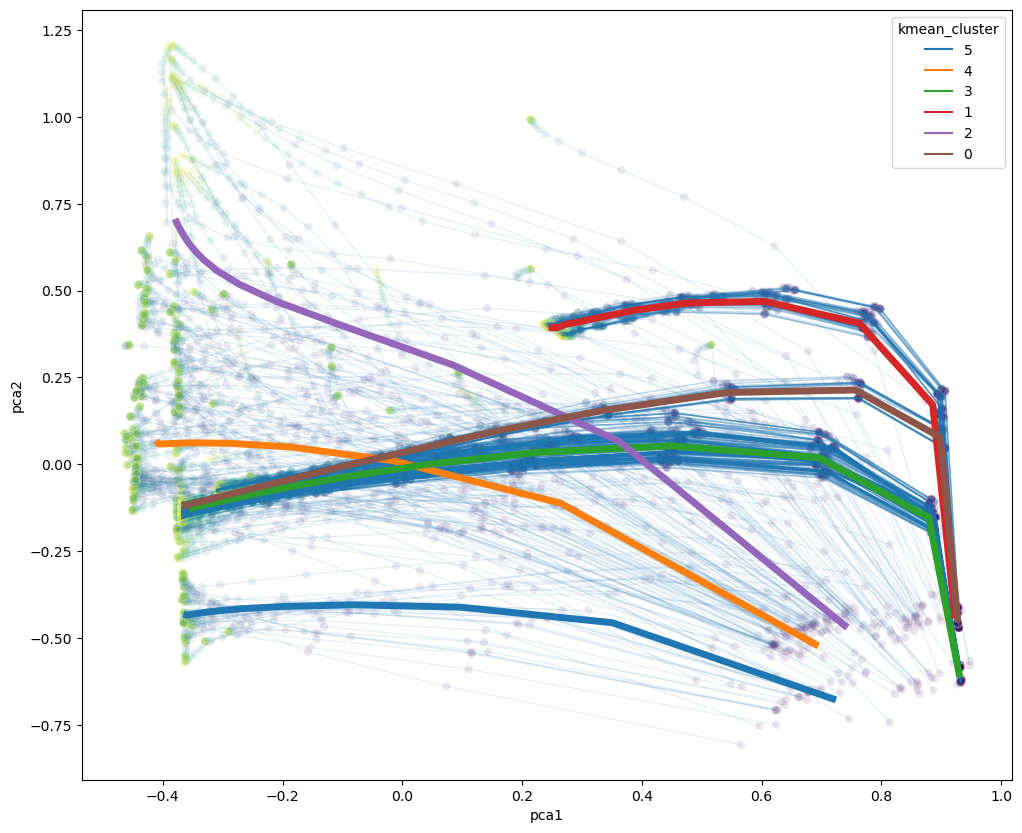

In [10]:
with rc_context({"figure.figsize": (12, 10)}):
    plot1 = sns.scatterplot(data = pca_mat, 
                x = 'pca1',y='pca2',
                c = pca_mat.timepoint, alpha = .1)
    
    plot2 = sns.lineplot(data = pca_mat, 
                x = 'pca1',y='pca2',
                units = 'model_id', estimator = None, lw=1, alpha = .1)
    
    plot3 = sns.lineplot(data = kmean_cluster, 
                            x = 'pca1',y='pca2',
                            hue = 'kmean_cluster',
                            sort = False, linewidth = 5, markersize = 10)
    
plt.show()

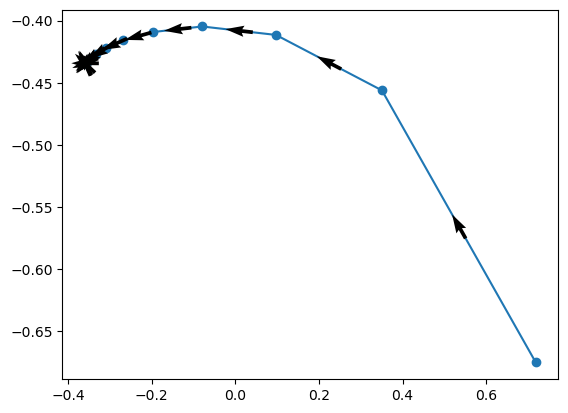

In [81]:
import numpy as np
df = kmean_cluster.loc[5]
x = df['pca1'].values
y = df['pca2'].values

u = np.diff(x)
v = np.diff(y)
pos_x = x[:-1] + u/2
pos_y = y[:-1] + v/2
norm = np.sqrt(u**2+v**2) 

fig, ax = plt.subplots()
ax.plot(x,y, marker="o")
ax.quiver(pos_x, pos_y, u/norm, v/norm, angles="xy", zorder=5, pivot="mid")
plt.show()

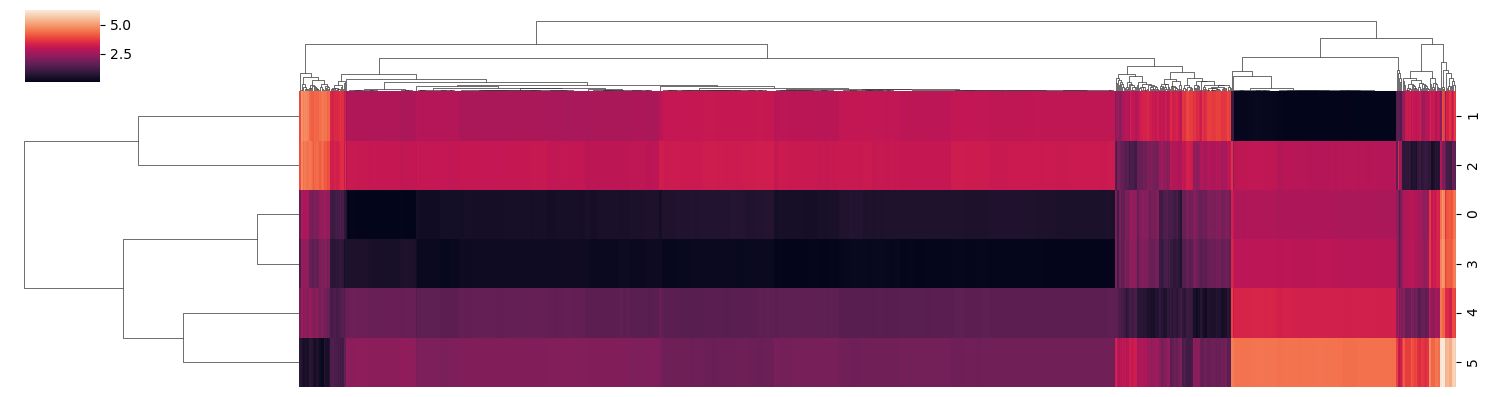

In [12]:
# Obtain the distance space from `tslearn`
distance_space = km.transform(pca_all_trajectory)
distance_space = pd.DataFrame(distance_space)
distance_space.index = list(model_pca_all.keys())

# Plot the distance space to each cluster for each model
sns.clustermap(distance_space.transpose(), figsize = (15,4), xticklabels=False)
plt.show()

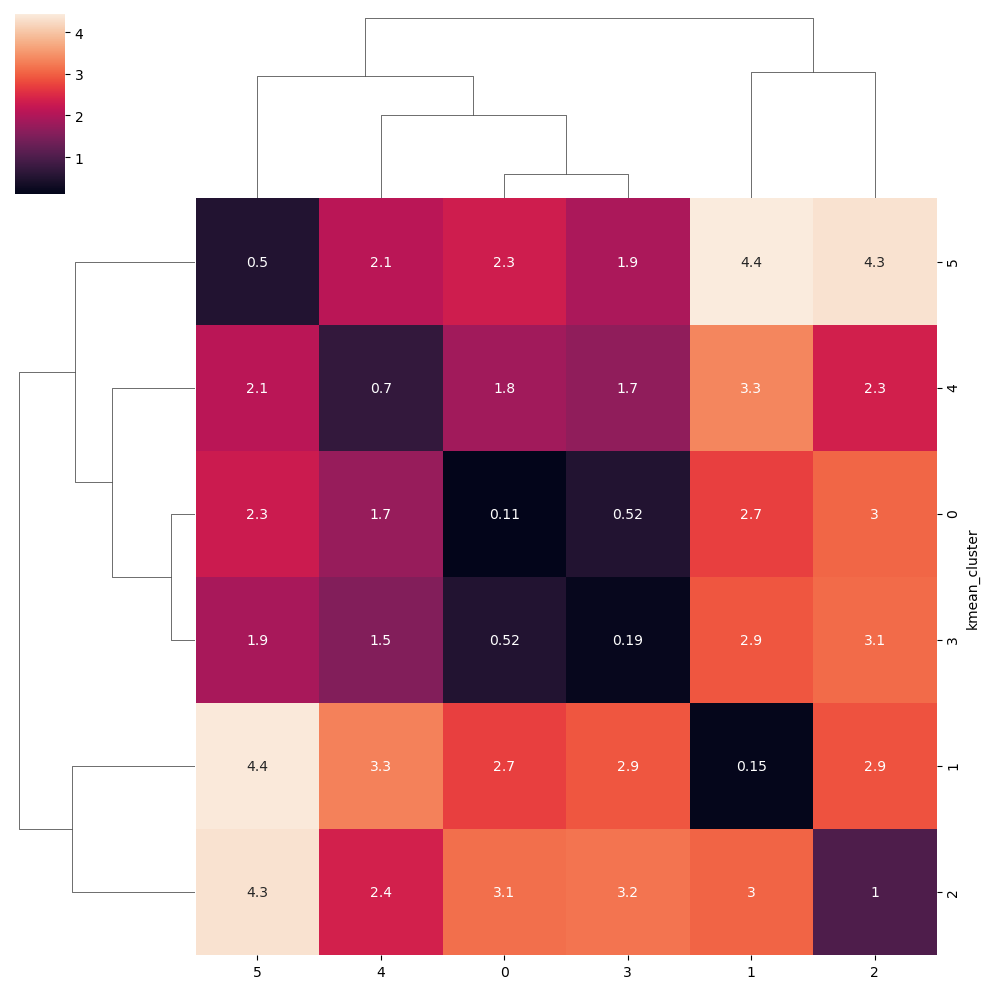

In [13]:
# Attach cluster information
distance_space['kmean_cluster'] = list(distance_space.index)
distance_space['kmean_cluster'] = distance_space['kmean_cluster'].replace(cluster_dict)
distance_space_group = distance_space.groupby(['kmean_cluster']).mean()

# Plot the distance space by group
sns.clustermap(distance_space_group, figsize = (10,10), annot = True)
plt.show()

In [14]:
distance_space.kmean_cluster.value_counts()

kmean_cluster
3    640
1    151
4     91
0     63
2     52
5     27
Name: count, dtype: int64

/home/spankaew/anaconda3/envs/scPROFILE/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/spankaew/anaconda3/envs/scPROFILE/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/spankaew/anaconda3/envs/scPROFILE/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/spankaew/anaconda3/envs/scPROFILE/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, me

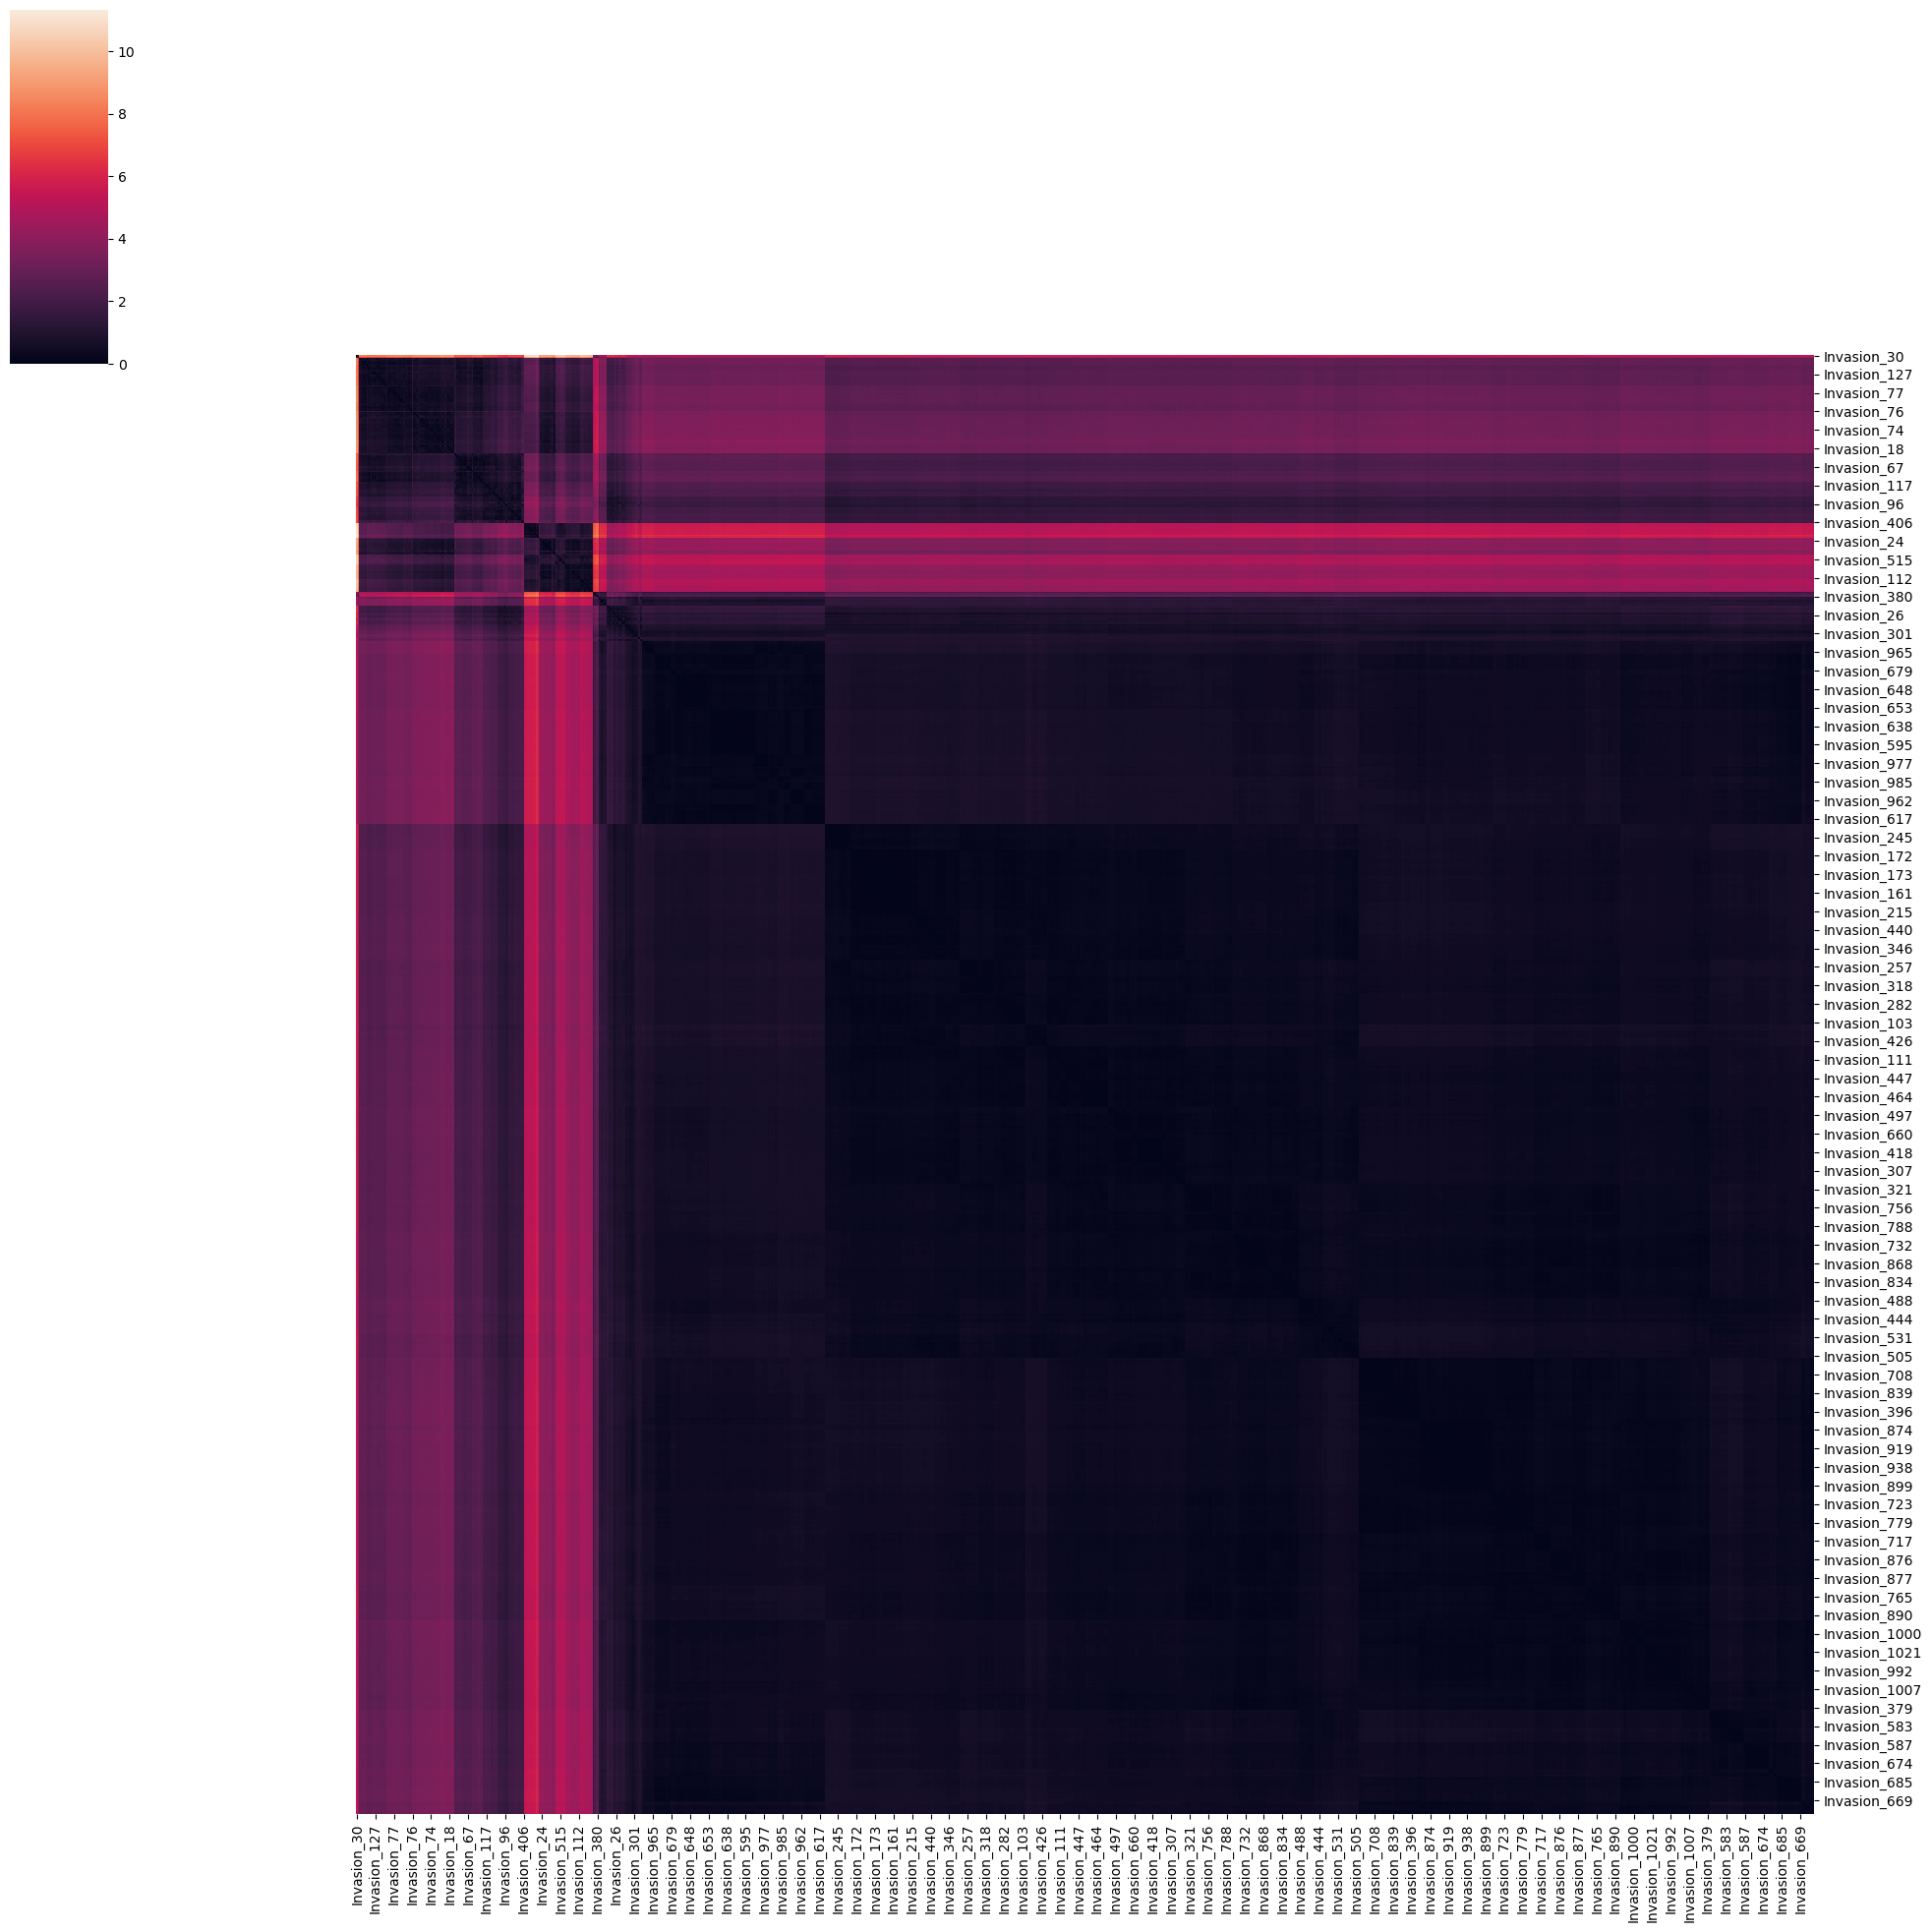

In [49]:
# Get model_id
model_id = list(cluster_dict.keys())

# Compact data into the right format
kmean_cluster = pca_mat.groupby(['model_id','timepoint'])[['pca1','pca2']].mean()

# Calculate Euclidean distances between clusters
distance_matrix = pd.DataFrame()
for i in model_id:
    time_series1 = numpy.array(kmean_cluster.loc[i])
    distance_cluster = []
    for j in model_id:
        time_series2 = numpy.array(kmean_cluster.loc[j])
        distance = numpy.sqrt(numpy.sum((time_series1 - time_series2)**2))
        distance_cluster.append(distance)
    distance_matrix = pd.concat([distance_matrix,pd.DataFrame(distance_cluster)],axis = 1)
distance_matrix.columns = model_id
distance_matrix.index = model_id

# Plot Euclidean distance using clustermap
g = sns.clustermap(distance_matrix, figsize = (20,20))

# Hiding the row dendrogram
g.ax_row_dendrogram.set_visible(False)

# Hiding the column dendrogram
g.ax_col_dendrogram.set_visible(False)

plt.show()

# Focus on logical function
In this part of the examples, we look at the logical function underlying each model and ask whether there is an association between logical equations and the model

In [15]:
# Get the list of files in the model folder
model_folder = '/home/spankaew/Git/BooleanBenchmark/models/Invasion/'
model_files = os.listdir(model_folder)

model_logic = pd.DataFrame()

for i in model_files:
    logic = pd.read_csv(model_folder + i, index_col=0, header = None)
    logic.columns = [i.split('.')[0]]
    model_logic = pd.concat([model_logic, logic], axis = 1, ignore_index=False)
model_logic.index.name = None
model_logic = model_logic.transpose()

In [16]:
cpal = ['#d73027', '#f46d43', '#fdae61', '#fee08b', '#ffffbf', '#d9ef8b', '#a6d96a', '#66bd63', '#1a9850', '#006837']

/home/spankaew/anaconda3/envs/scPROFILE/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


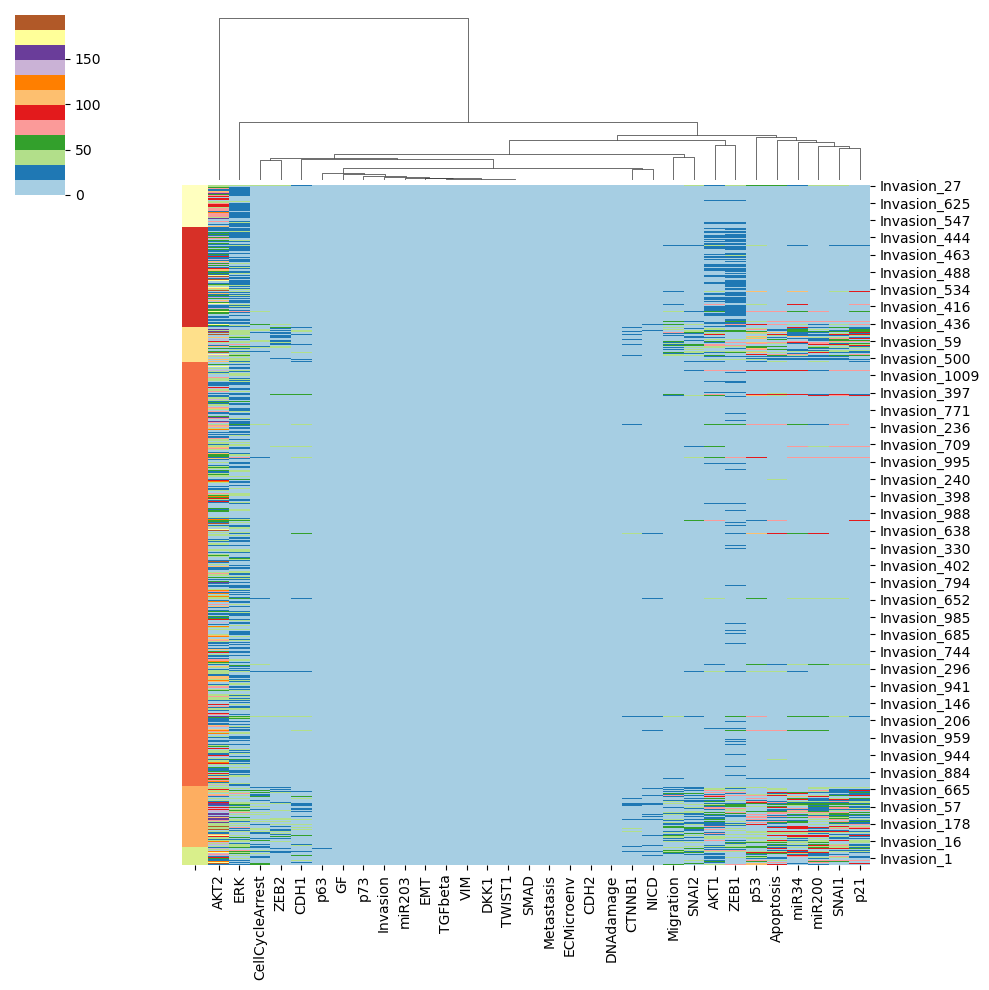

In [17]:
model_logic_categorical = model_logic.copy()
for i in model_logic_categorical.columns:
    model_logic_categorical[i], _ = pd.factorize(model_logic[i])

# Create cluster color palette
kmean_index = pd.Series(model_logic.index, index = model_logic.index)
kmean_index = kmean_index.replace(cluster_dict)
lut = dict(zip(kmean_index.unique(), cpal))
row_colors = kmean_index.map(lut)

sort_index = list(kmean_index.sort_values().index)

# Plot clustermap
sns.clustermap(model_logic_categorical.loc[sort_index],
            row_colors = row_colors[sort_index], 
            row_cluster=False,
            col_cluster = True,
            cmap = 'Paired')

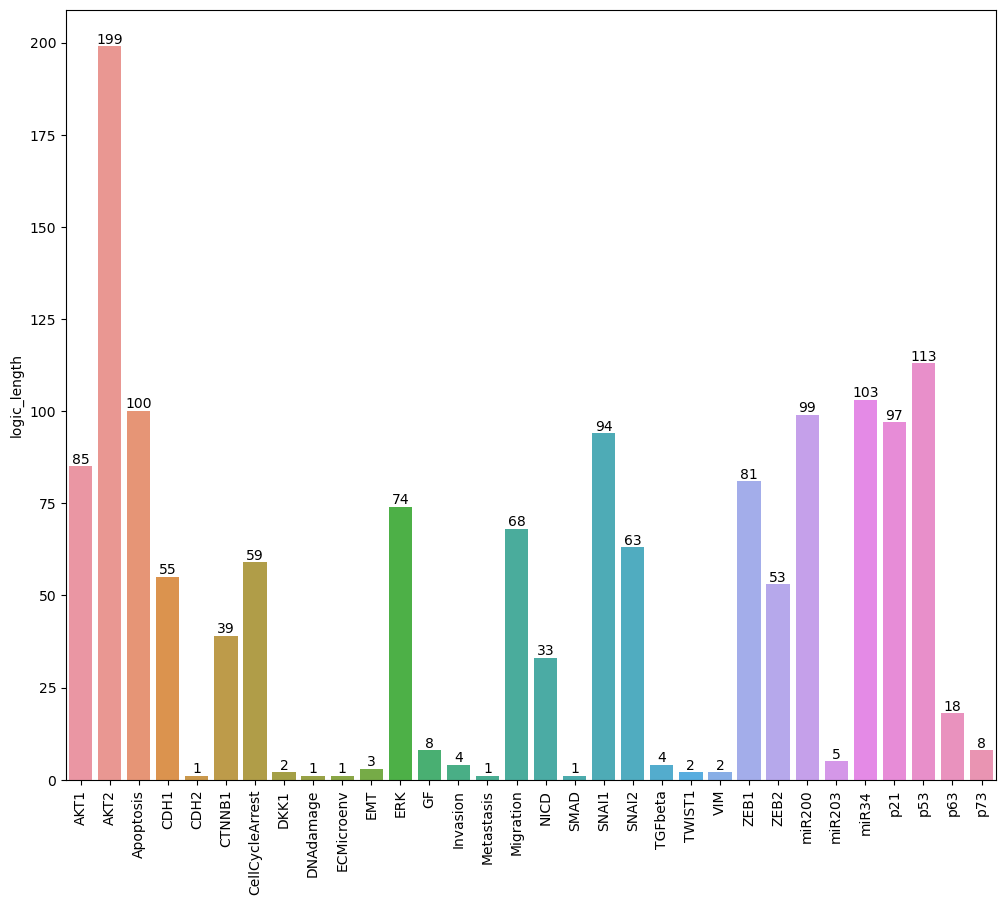

In [18]:
var_logic_length = []
for i in model_logic.columns:
    num_logic = model_logic[i].value_counts().size
    var_logic_length.append(num_logic)
var_logic_length = pd.DataFrame(var_logic_length, columns = ['logic_length'], index = model_logic.columns)

with rc_context({"figure.figsize": (12, 10)}):
    ax = sns.barplot(x = var_logic_length.index, 
                y = var_logic_length.logic_length)
    ax.bar_label(ax.containers[0], fontsize=10);
    plt.xticks(rotation = 90)
plt.show()

In [45]:
model_logic['kmean_cluster'] = list(model_logic.index)
model_logic['kmean_cluster'] = model_logic['kmean_cluster'].replace(cluster_dict)


var_logic_clust = pd.DataFrame()
for i in list(range(6)):
    model_logic_sub = model_logic.loc[model_logic.kmean_cluster == i]
    model_logic_sub = model_logic_sub.drop(['kmean_cluster'], axis = 1)
    var_logic_length = []
    for j in model_logic_sub.columns:
        num_logic = model_logic_sub[j].value_counts().size
        var_logic_length.append(num_logic)
    var_logic_length = pd.DataFrame(var_logic_length, columns = ['logic_length'], index = model_logic_sub.columns)
    var_logic_clust = pd.concat([var_logic_clust, var_logic_length], axis = 1, ignore_index = False)
var_logic_clust.columns = list(range(6))

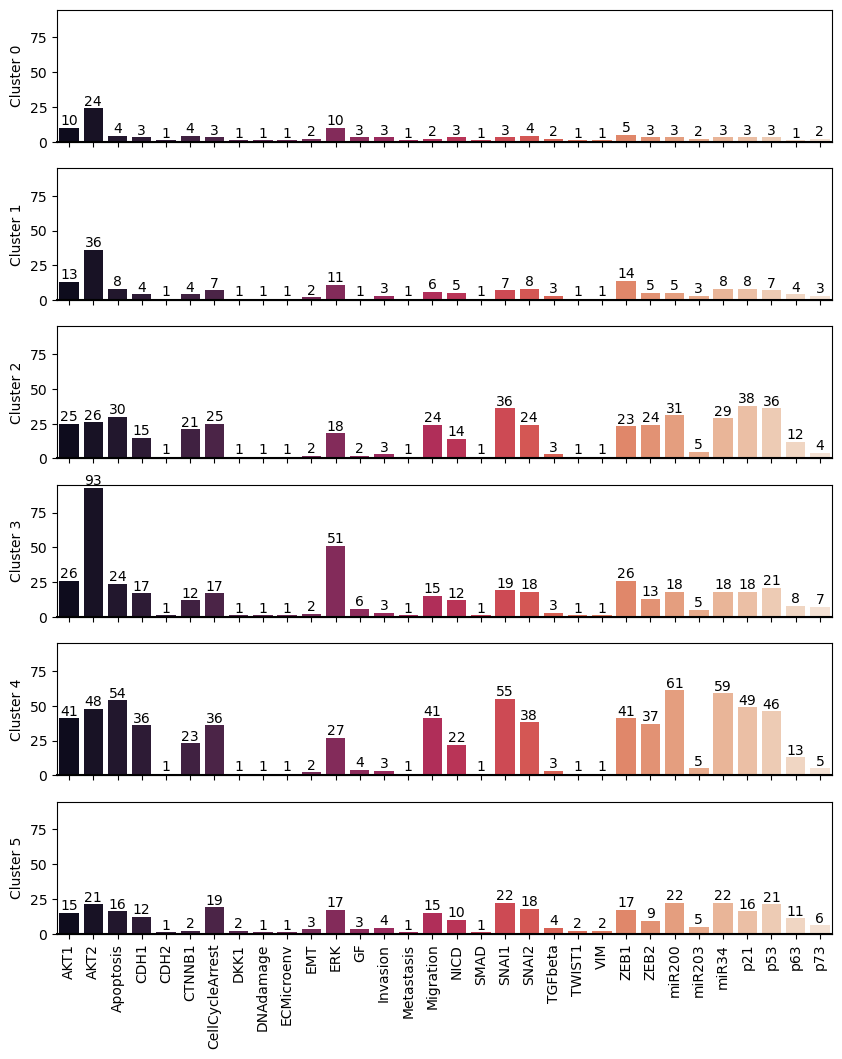

In [55]:
f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(10, 12), sharex=True)
plt.ylim(0,65)

sns.barplot(x=var_logic_clust.index, y=var_logic_clust[0], palette="rocket", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Cluster 0")
ax1.bar_label(ax1.containers[0], fontsize=10)
ax1.set_ylim(0,95)

sns.barplot(x=var_logic_clust.index, y=var_logic_clust[1], palette="rocket", ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
ax2.set_ylabel("Cluster 1")
ax2.bar_label(ax2.containers[0], fontsize=10)
ax2.set_ylim(0,95)

sns.barplot(x=var_logic_clust.index, y=var_logic_clust[2], palette="rocket", ax=ax3)
ax3.axhline(0, color="k", clip_on=False)
ax3.set_ylabel("Cluster 2")
ax3.bar_label(ax3.containers[0], fontsize=10)
ax3.set_ylim(0,95)

sns.barplot(x=var_logic_clust.index, y=var_logic_clust[3], palette="rocket", ax=ax4)
ax4.axhline(0, color="k", clip_on=False)
ax4.set_ylabel("Cluster 3")
ax4.bar_label(ax4.containers[0], fontsize=10)
ax4.set_ylim(0,95)

sns.barplot(x=var_logic_clust.index, y=var_logic_clust[4], palette="rocket", ax=ax5)
ax5.axhline(0, color="k", clip_on=False)
ax5.set_ylabel("Cluster 4")
ax5.bar_label(ax5.containers[0], fontsize=10)
ax5.set_ylim(0,95)

sns.barplot(x=var_logic_clust.index, y=var_logic_clust[5], palette="rocket", ax=ax6)
ax6.axhline(0, color="k", clip_on=False)
ax6.set_ylabel("Cluster 5")
ax6.bar_label(ax6.containers[0], fontsize=10)
ax6.set_ylim(0,95)

plt.xticks(rotation = 90)
plt.show()

In [65]:
pca_mat.kmean_cluster.value_counts()/19

kmean_cluster
3    640.0
1    151.0
4     91.0
0     63.0
2     52.0
5     27.0
Name: count, dtype: float64